In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.family"] = "Arial"

import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

from utils.data_processing import process_string

from config.variables import (
    daynum_dict_short,
    nutri_macro_vars,
    amount_vars,
    nutri_micro_vars,
    nutri_fg_vars,
    nutri_cfg_vars,
)

from tqdm import tqdm

## Loading metadata and aggregated food data

In [18]:
fay = pd.read_csv("./data/fay_meta_may24.csv", index_col=0)

In [19]:
df_food_filtered_agg = pd.read_csv("data/df_food_filtered_agg.csv")

In [20]:
fay_with_summedFood = fay[["age", "bmi", "gender", "subject_app_key"]].merge(
    df_food_filtered_agg, left_on="subject_app_key", right_on="subject_key"
)

## Modeling functions

In [21]:
def create_linear_mixed_model(
    dfmain, target_var, show_warnings=False, return_summary=True
):
    """
    Create and fit a linear mixed model for the given DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing columns 'age', 'bmi', 'gender',
                       'subject_key', 'day_of_week', and target variable.
    target_var (str): The name of the target variable for the model.

    Returns:
    MixedLMResults or None: The fitted mixed linear model summary or None if convergence warning occurs.
    """
    df = dfmain.copy()

    # # Ensure categorical variables are treated as such
    df["day_of_week"] = df["day_of_week"].astype("category")
    df["subject_key"] = df["subject_key"].astype("category")

    # Define the model formula
    if df["gender"].nunique() == 1:
        model_formula = (
            f"{target_var} ~ age + bmi + C(day_of_week, Treatment(reference=0))"
        )
    else:
        model_formula = f'{target_var} ~ age + bmi + C(gender, Treatment(reference="male")) + C(day_of_week, Treatment(reference=0))'

    # Create the mixed linear model
    model = mixedlm(model_formula, df, groups=df["subject_key"])

    # Fit the model with warning handling
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always", ConvergenceWarning)
        result = model.fit()

        if show_warnings == True:
            for warning in w:
                print(warning)
        else:
            # Check for convergence warnings
            for warning in w:
                if issubclass(warning.category, ConvergenceWarning):
                    return None

    if return_summary:
        return result.summary()
    else:
        return result

In [22]:
def compute_lmm_results(
    df,
    col_list,
    ignore_vars=[
        "subject_key",
        "day_of_week",
        "energy_kj_eaten",
        "alcohol_fg_eaten",
        "others_fg_eaten",
    ],
):

    lmm_res_dof_coeff = pd.DataFrame()
    lmm_res_dof_pval = pd.DataFrame()

    convergence_warning_cols = []

    for col in tqdm(col_list):
        if col in ignore_vars:
            continue

        lmm_summary_df = create_linear_mixed_model(df, col)

        if lmm_summary_df is None:
            convergence_warning_cols.append(col)
            continue

        lmm_summary_intercept = lmm_summary_df.tables[1].loc["Intercept"]["Coef."]
        lmm_summary_df_dof = lmm_summary_df.tables[1][
            lmm_summary_df.tables[1].index.str.contains("day_of_week")
        ]

        lmm_summary_df_dof_coef = lmm_summary_df_dof[["Coef."]].copy()
        lmm_summary_df_dof_pval = lmm_summary_df_dof[["P>|z|"]].copy()

        colname_for_coeff = process_string(
            col, ignore_vars=[], newLineSep=6
        )  # + " " + f"({lmm_summary_intercept})"
        colname_for_pval = process_string(
            col, ignore_vars=[], newLineSep=6
        )  # + " " + f"({lmm_summary_intercept})"
        lmm_summary_df_dof_coef.rename(
            columns={"Coef.": colname_for_coeff}, inplace=True
        )
        lmm_summary_df_dof_pval.rename(
            columns={"P>|z|": colname_for_pval}, inplace=True
        )

        lmm_summary_df_dof_coef = lmm_summary_df_dof_coef.astype(float)
        lmm_summary_df_dof_pval = lmm_summary_df_dof_pval.astype(float)

        lmm_res_dof_coeff = pd.concat(
            [lmm_res_dof_coeff, lmm_summary_df_dof_coef], axis=1
        )
        lmm_res_dof_pval = pd.concat(
            [lmm_res_dof_pval, lmm_summary_df_dof_pval], axis=1
        )

    #### Sort Option 1: based on the sum of p-values
    ## column_order = lmm_res_dof_pval.sum(axis=0).sort_values().index ## sort by sum of p-values
    #### Sort Option 2: alphabetical
    # column_order = sorted(lmm_res_dof_pval.columns ) ## sort by alphabetical
    # lmm_res_dof_coeff = lmm_res_dof_coeff[column_order]
    # lmm_res_dof_pval = lmm_res_dof_pval[column_order]

    print(
        f"Convergence warnings for {len(convergence_warning_cols)} columns: {convergence_warning_cols}"
    )

    return (
        lmm_res_dof_coeff.round(3),
        lmm_res_dof_pval.round(3),
        convergence_warning_cols,
    )

In [23]:
def custom_colormap_pvals(val):
    if val < 0.001:
        return "#EA3C53"
    elif val < 0.01:
        return "orange"
    elif val < 0.05:
        return "gold"
    else:
        return "lightgrey"


def plot_lmm_heatmap_with_coeff_and_pval(
    df,
    coef_data,
    categories=None,
    title="Linear Mixed Model Coefficients and P-Values",
    save_path=None,
    hide_image=True,
    show_legend=False,
    toplabel=None,
    toplabel_pos=(0, 0.95),
    figsize=(5, 11),
):
    pval_data = df.copy()
    pval_data.columns = [
        daynum_dict_short[int(var[-2])] for var in pval_data.columns
    ]  # Convert LMM Var names to day names

    # Apply the custom colormap to the p-value data
    colors = pval_data.map(custom_colormap_pvals)

    # Create a heatmap with the p-values

    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        pval_data,
        annot=False,
        cmap=ListedColormap(["white"]),
        cbar=False,
        linewidths=0.5,
        linecolor="gray",
        ax=ax,
    )

    # Manually set the cell colors and add coefficient annotations
    for i in range(pval_data.shape[0]):
        for j in range(pval_data.shape[1]):
            ax.add_patch(
                plt.Rectangle(
                    (j, i),
                    1,
                    1,
                    fill=True,
                    color=colors.iloc[i, j],
                    edgecolor="gray",
                    lw=0.5,
                )
            )
            ax.text(
                j + 0.5,
                i + 0.5,
                f"{coef_data.iloc[i, j]:.2f}",
                ha="center",
                va="center",
                color="black",
            )

    ax.set_title(title)

    # Create custom legend
    legend_handles = [
        mpatches.Patch(color="#EA3C53", label="p < 0.001"),
        mpatches.Patch(color="orange", label="p < 0.01"),
        mpatches.Patch(color="gold", label="p < 0.05"),
        mpatches.Patch(color="lightgrey", label="p >= 0.05"),
    ]

    ## make the legend border invisible
    if show_legend:
        ax.legend(
            handles=legend_handles,
            title="P-Value",
            bbox_to_anchor=(-0.7, 0.97),
            loc="upper left",
            fontsize=10,
            frameon=True,
        )

    ## Add figure label
    if toplabel:
        fig.text(
            toplabel_pos[0],
            toplabel_pos[1],
            toplabel,
            ha="center",
            fontsize=15,
            fontweight="bold",
        )

    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")

    if hide_image:
        plt.close(fig)
    else:
        plt.show()

In [24]:
col_list_lmm = (
    sorted(nutri_macro_vars)
    + sorted(amount_vars)
    + sorted(nutri_micro_vars)
    + sorted(nutri_fg_vars)
    + sorted(nutri_cfg_vars)
)
col_list_lmm = [i for i in col_list_lmm if i in df_food_filtered_agg.columns]

lmm_res_dof_coeff, lmm_res_dof_pval, convergence_warning_cols = compute_lmm_results(
    fay_with_summedFood, col_list_lmm
)

100%|██████████| 52/52 [00:39<00:00,  1.31it/s]

Convergence warnings for 15 columns: ['beta_carotene_eaten', 'fatty_acids_monounsaturated_eaten', 'folate_eaten', 'iron_eaten', 'magnesium_eaten', 'niacin_eaten', 'pantothenic_acid_eaten', 'vitamin_b12_eaten', 'vitamin_b1_eaten', 'vitamin_b2_eaten', 'vitamin_b6_eaten', 'vitamin_c_eaten', 'vitamin_d_eaten', 'zinc_eaten', 'fast_food_fg_eaten']


958

/var/folders/kl/wv2_2q3n4z3d2bxtztx97rgc0000gn/T/ipykernel_49601/1811583747.py:49: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle(


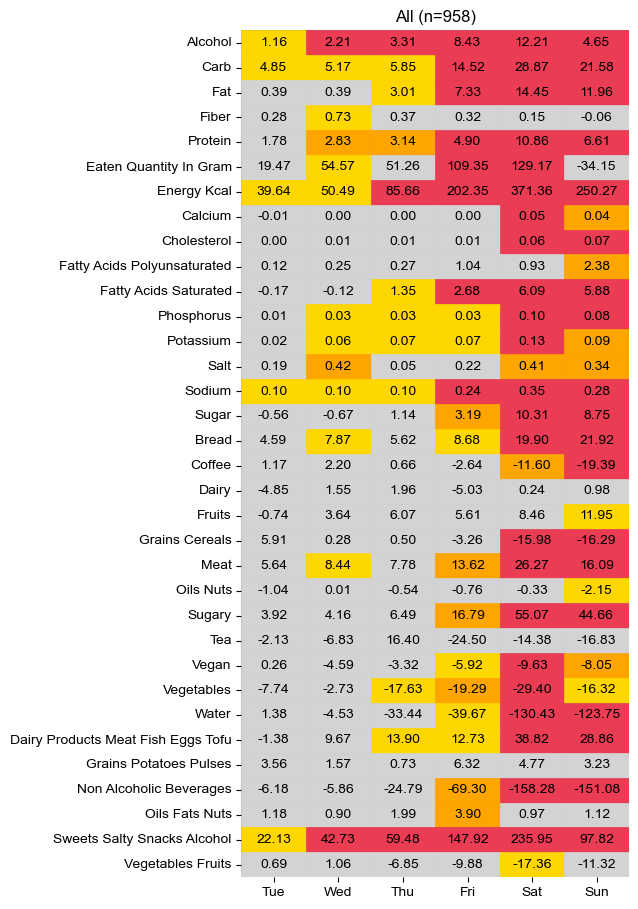

In [29]:
plot_lmm_heatmap_with_coeff_and_pval(
    df=lmm_res_dof_pval.T,
    coef_data=lmm_res_dof_coeff.T,
    categories=None,
    title=f"All (n={fay_with_summedFood["subject_app_key"].nunique()})",
    save_path="figures/lmm_heatmap_all.png",
    hide_image=False,
    toplabel="",
    toplabel_pos=(0, 0.9),
)

### Subsetting for age

In [11]:
cols_to_consider = col_list_lmm 

### Subsetting for age (young)
fay_with_summedFood_subset = fay_with_summedFood[fay_with_summedFood["age"] <= 35]
print("Shape for young data", fay_with_summedFood_subset.shape)
lmm_res_dof_coeff_young, lmm_res_dof_pval_young, _ = compute_lmm_results(
    fay_with_summedFood_subset, cols_to_consider
)

### Subsetting for age (middle-age)
fay_with_summedFood_subset = fay_with_summedFood[
    (fay_with_summedFood["age"] < 50) & (fay_with_summedFood["age"] > 35)
]
print("Shape for middleage data", fay_with_summedFood_subset.shape)
lmm_res_dof_coeff_middleage, lmm_res_dof_pval_middleage, _ = compute_lmm_results(
    fay_with_summedFood_subset, cols_to_consider
)

### Subsetting for age (old)
fay_with_summedFood_subset = fay_with_summedFood[fay_with_summedFood["age"] >= 50]
print("Shape for old data", fay_with_summedFood_subset.shape)
lmm_res_dof_coeff_old, lmm_res_dof_pval_old, _ = compute_lmm_results(
    fay_with_summedFood_subset, cols_to_consider
)

# Option 1: common columns for young and old
p1 = lmm_res_dof_pval_young.columns.map(lambda i: i.split("(")[0])
p2 = lmm_res_dof_pval_old.columns.map(lambda i: i.split("(")[0])
p3 = lmm_res_dof_pval_middleage.columns.map(lambda i: i.split("(")[0])

common_cols = set(p1).intersection(set(p2)).intersection(set(p3))
common_for_young = sorted(
    [i for i in lmm_res_dof_pval_young.columns if i.split("(")[0] in common_cols]
)
common_for_old = sorted(
    [i for i in lmm_res_dof_pval_old.columns if i.split("(")[0] in common_cols]
)
common_for_middleage = sorted(
    [i for i in lmm_res_dof_pval_middleage.columns if i.split("(")[0] in common_cols]
)

print("Common Columns that converged for young and old", len(common_cols))
lmm_res_dof_coeff_young = lmm_res_dof_coeff_young[common_for_young]
lmm_res_dof_pval_young = lmm_res_dof_pval_young[common_for_young]
lmm_res_dof_coeff_old = lmm_res_dof_coeff_old[common_for_old]
lmm_res_dof_pval_old = lmm_res_dof_pval_old[common_for_old]
lmm_res_dof_coeff_middleage = lmm_res_dof_coeff_middleage[common_for_middleage]
lmm_res_dof_pval_middleage = lmm_res_dof_pval_middleage[common_for_middleage]

## Plotting the heatmap for young and old
plot_lmm_heatmap_with_coeff_and_pval(
    df=lmm_res_dof_pval_young.T,
    coef_data=lmm_res_dof_coeff_young.T,
    title="Age (<=35yrs)",
    save_path="figures/lmm/lmm_heatmap_young.png",
    hide_image=True,
    toplabel="A",
    toplabel_pos=(-0.1, 0.9),
    figsize=(5, 11),
    show_legend=False,
)
plot_lmm_heatmap_with_coeff_and_pval(
    df=lmm_res_dof_pval_old.T,
    coef_data=lmm_res_dof_coeff_old.T,
    title="Age (>=50yrs)",
    save_path="figures/lmm/lmm_heatmap_old.png",
    hide_image=True,
    toplabel="C",
    toplabel_pos=(-0.1, 0.9),
    figsize=(5, 11),
    show_legend=False,
)
plot_lmm_heatmap_with_coeff_and_pval(
    df=lmm_res_dof_pval_middleage.T,
    coef_data=lmm_res_dof_coeff_middleage.T,
    title="Age (36-49yrs)",
    save_path="figures/lmm/lmm_heatmap_middleage.png",
    hide_image=True,
    toplabel="B",
    toplabel_pos=(-0.1, 0.9),
    figsize=(5, 11),
    show_legend=False,
)

# del fay_with_summedFood_subset, lmm_res_dof_coeff_young, lmm_res_dof_coeff_old, lmm_res_dof_pval_young, lmm_res_dof_pval_old, p1, p2, common_cols, common_for_young, common_for_old

Shape for young data (3073, 58)


100%|██████████| 52/52 [00:21<00:00,  2.40it/s]


Convergence warnings for 15 columns: ['beta_carotene_eaten', 'fatty_acids_polyunsaturated_eaten', 'folate_eaten', 'iron_eaten', 'magnesium_eaten', 'niacin_eaten', 'pantothenic_acid_eaten', 'vitamin_b12_eaten', 'vitamin_b1_eaten', 'vitamin_b2_eaten', 'vitamin_b6_eaten', 'vitamin_c_eaten', 'vitamin_d_eaten', 'zinc_eaten', 'fast_food_fg_eaten']
Shape for middleage data (2303, 58)


100%|██████████| 52/52 [00:10<00:00,  4.85it/s]


Convergence warnings for 14 columns: ['beta_carotene_eaten', 'folate_eaten', 'iron_eaten', 'magnesium_eaten', 'niacin_eaten', 'pantothenic_acid_eaten', 'salt_eaten', 'vitamin_b12_eaten', 'vitamin_b1_eaten', 'vitamin_b2_eaten', 'vitamin_b6_eaten', 'vitamin_c_eaten', 'vitamin_d_eaten', 'zinc_eaten']
Shape for old data (1330, 58)


100%|██████████| 52/52 [00:05<00:00,  9.78it/s]
/var/folders/kl/wv2_2q3n4z3d2bxtztx97rgc0000gn/T/ipykernel_49601/2065938182.py:50: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle(


Convergence warnings for 13 columns: ['beta_carotene_eaten', 'folate_eaten', 'iron_eaten', 'magnesium_eaten', 'niacin_eaten', 'pantothenic_acid_eaten', 'vitamin_b12_eaten', 'vitamin_b1_eaten', 'vitamin_b2_eaten', 'vitamin_b6_eaten', 'vitamin_c_eaten', 'vitamin_d_eaten', 'zinc_eaten']
Common Columns that converged for young and old 33


/var/folders/kl/wv2_2q3n4z3d2bxtztx97rgc0000gn/T/ipykernel_49601/2065938182.py:50: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle(
/var/folders/kl/wv2_2q3n4z3d2bxtztx97rgc0000gn/T/ipykernel_49601/2065938182.py:50: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle(


### Subsetting for BMI

In [12]:
cols_to_consider = col_list_lmm 

### Subsetting for bmi (normalBMI)
fay_with_summedFood_subset = fay_with_summedFood[
    (fay_with_summedFood["bmi"] >= 18) & (fay_with_summedFood["bmi"] <= 25)
]
print(
    "Shape for normalBMI data",
    fay_with_summedFood_subset.shape,
    fay_with_summedFood_subset["subject_app_key"].nunique(),
)
lmm_res_dof_coeff_normalBMI, lmm_res_dof_pval_normalBMI, _ = compute_lmm_results(
    fay_with_summedFood_subset, cols_to_consider
)

### Subsetting for bmi (highBMI)
fay_with_summedFood_subset = fay_with_summedFood[fay_with_summedFood["bmi"] > 25]
print(
    "Shape for highBMI data",
    fay_with_summedFood_subset.shape,
    fay_with_summedFood_subset["subject_app_key"].nunique(),
)
lmm_res_dof_coeff_highBMI, lmm_res_dof_pval_highBMI, _ = compute_lmm_results(
    fay_with_summedFood_subset, cols_to_consider
)

## common columns for normalBMI and highBMI
p1 = lmm_res_dof_pval_normalBMI.columns.map(lambda i: i.split("(")[0])
p2 = lmm_res_dof_pval_highBMI.columns.map(lambda i: i.split("(")[0])

common_cols = set(p1).intersection(set(p2))
common_for_normalBMI = sorted(
    [i for i in lmm_res_dof_pval_normalBMI.columns if i.split("(")[0] in common_cols]
)
common_for_highBMI = sorted(
    [i for i in lmm_res_dof_pval_highBMI.columns if i.split("(")[0] in common_cols]
)

print("Common Columns that converged for normalBMI and highBMI", len(common_cols))
lmm_res_dof_coeff_normalBMI = lmm_res_dof_coeff_normalBMI[common_for_normalBMI]
lmm_res_dof_pval_normalBMI = lmm_res_dof_pval_normalBMI[common_for_normalBMI]
lmm_res_dof_coeff_highBMI = lmm_res_dof_coeff_highBMI[common_for_highBMI]
lmm_res_dof_pval_highBMI = lmm_res_dof_pval_highBMI[common_for_highBMI]

## Plotting the heatmap for normalBMI and highBMI
plot_lmm_heatmap_with_coeff_and_pval(
    df=lmm_res_dof_pval_normalBMI.T,
    coef_data=lmm_res_dof_coeff_normalBMI.T,
    title="BMI (18-25)",
    save_path="figures/lmm/lmm_heatmap_normalBMI.png",
    hide_image=True,
    toplabel="A",
    toplabel_pos=(-0.1, 0.9),
    figsize=(5, 11),
    show_legend=False,
)
plot_lmm_heatmap_with_coeff_and_pval(
    df=lmm_res_dof_pval_highBMI.T,
    coef_data=lmm_res_dof_coeff_highBMI.T,
    title="BMI (>25)",
    save_path="figures/lmm/lmm_heatmap_highBMI.png",
    hide_image=True,
    toplabel="B",
    toplabel_pos=(-0.1, 0.9),
    figsize=(5, 11),
    show_legend=False,
)

del (
    fay_with_summedFood_subset,
    lmm_res_dof_coeff_normalBMI,
    lmm_res_dof_coeff_highBMI,
    lmm_res_dof_pval_normalBMI,
    lmm_res_dof_pval_highBMI,
    p1,
    p2,
    common_cols,
    common_for_normalBMI,
    common_for_highBMI,
)

Shape for normalBMI data (4662, 58) 666


100%|██████████| 52/52 [00:22<00:00,  2.28it/s]


Convergence warnings for 14 columns: ['beta_carotene_eaten', 'fatty_acids_monounsaturated_eaten', 'folate_eaten', 'iron_eaten', 'magnesium_eaten', 'niacin_eaten', 'pantothenic_acid_eaten', 'vitamin_b12_eaten', 'vitamin_b1_eaten', 'vitamin_b2_eaten', 'vitamin_b6_eaten', 'vitamin_c_eaten', 'vitamin_d_eaten', 'zinc_eaten']
Shape for highBMI data (1967, 58) 281


100%|██████████| 52/52 [00:13<00:00,  3.84it/s]
/var/folders/kl/wv2_2q3n4z3d2bxtztx97rgc0000gn/T/ipykernel_49601/2065938182.py:50: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle(


Convergence warnings for 15 columns: ['beta_carotene_eaten', 'cholesterol_eaten', 'folate_eaten', 'iron_eaten', 'magnesium_eaten', 'niacin_eaten', 'pantothenic_acid_eaten', 'vitamin_b12_eaten', 'vitamin_b1_eaten', 'vitamin_b2_eaten', 'vitamin_b6_eaten', 'vitamin_c_eaten', 'vitamin_d_eaten', 'zinc_eaten', 'fast_food_fg_eaten']
Common Columns that converged for normalBMI and highBMI 33


/var/folders/kl/wv2_2q3n4z3d2bxtztx97rgc0000gn/T/ipykernel_49601/2065938182.py:50: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle(


### Subsetting for Gender

In [13]:
cols_to_consider = col_list_lmm 

### Subsetting for bmi (male)
fay_with_summedFood_subset = fay_with_summedFood[
    (fay_with_summedFood["gender"] == "male")
]
print(
    "Shape for male data",
    fay_with_summedFood_subset.shape,
    fay_with_summedFood_subset["subject_app_key"].nunique(),
)
lmm_res_dof_coeff_male, lmm_res_dof_pval_male, _ = compute_lmm_results(
    fay_with_summedFood_subset, cols_to_consider
)

### Subsetting for bmi (female)
fay_with_summedFood_subset = fay_with_summedFood[
    (fay_with_summedFood["gender"] == "female")
]
print(
    "Shape for female data",
    fay_with_summedFood_subset.shape,
    fay_with_summedFood_subset["subject_app_key"].nunique(),
)
lmm_res_dof_coeff_female, lmm_res_dof_pval_female, _ = compute_lmm_results(
    fay_with_summedFood_subset, cols_to_consider
)

## common columns for male and female
p1 = lmm_res_dof_pval_male.columns.map(lambda i: i.split("(")[0])
p2 = lmm_res_dof_pval_female.columns.map(lambda i: i.split("(")[0])

# common_cols = set(p1).intersection(set(p2))
# common_for_male = sorted([i for i in lmm_res_dof_pval_male.columns if i.split("(")[0] in common_cols])
# common_for_female = sorted([i for i in lmm_res_dof_pval_female.columns if i.split("(")[0] in common_cols])

# print("Common Columns that converged for male and female",len(common_cols))
# lmm_res_dof_coeff_male = lmm_res_dof_coeff_male[common_for_male]
# lmm_res_dof_pval_male = lmm_res_dof_pval_male[common_for_male]
# lmm_res_dof_coeff_female = lmm_res_dof_coeff_female[common_for_female]
# lmm_res_dof_pval_female = lmm_res_dof_pval_female[common_for_female]

## Plotting the heatmap for male and female
plot_lmm_heatmap_with_coeff_and_pval(
    df=lmm_res_dof_pval_male.T,
    coef_data=lmm_res_dof_coeff_male.T,
    title="Male",
    save_path="figures/lmm/lmm_heatmap_male.png",
    hide_image=True,
    toplabel="A",
    toplabel_pos=(-0.1, 0.9),
    figsize=(5, 11),
    show_legend=False,
)
plot_lmm_heatmap_with_coeff_and_pval(
    df=lmm_res_dof_pval_female.T,
    coef_data=lmm_res_dof_coeff_female.T,
    title="Female",
    save_path="figures/lmm/lmm_heatmap_female.png",
    hide_image=True,
    toplabel="B",
    toplabel_pos=(-0.1, 0.9),
    figsize=(5, 11),
    show_legend=False,
)

# del fay_with_summedFood_subset, lmm_res_dof_coeff_male, lmm_res_dof_coeff_female, lmm_res_dof_pval_male, lmm_res_dof_pval_female, p1, p2, common_cols, common_for_male, common_for_female

Shape for male data (2933, 58) 419


100%|██████████| 52/52 [00:14<00:00,  3.48it/s]


Convergence warnings for 14 columns: ['beta_carotene_eaten', 'fatty_acids_monounsaturated_eaten', 'folate_eaten', 'iron_eaten', 'magnesium_eaten', 'niacin_eaten', 'pantothenic_acid_eaten', 'vitamin_b12_eaten', 'vitamin_b1_eaten', 'vitamin_b2_eaten', 'vitamin_b6_eaten', 'vitamin_c_eaten', 'vitamin_d_eaten', 'zinc_eaten']
Shape for female data (3773, 58) 539


100%|██████████| 52/52 [00:23<00:00,  2.24it/s]
/var/folders/kl/wv2_2q3n4z3d2bxtztx97rgc0000gn/T/ipykernel_49601/2065938182.py:50: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle(


Convergence warnings for 16 columns: ['beta_carotene_eaten', 'cholesterol_eaten', 'folate_eaten', 'iron_eaten', 'magnesium_eaten', 'niacin_eaten', 'pantothenic_acid_eaten', 'salt_eaten', 'vitamin_b12_eaten', 'vitamin_b1_eaten', 'vitamin_b2_eaten', 'vitamin_b6_eaten', 'vitamin_c_eaten', 'vitamin_d_eaten', 'zinc_eaten', 'fast_food_fg_eaten']


/var/folders/kl/wv2_2q3n4z3d2bxtztx97rgc0000gn/T/ipykernel_49601/2065938182.py:50: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle(


### For Seasonal Variation

In [14]:
print(
    pd.to_datetime(fay["start_date"]).map(lambda x: x.month).value_counts().sort_index()
)


def season_assigner(num):
    if num in [11, 12, 1, 2, 3, 4]:
        return "cold"
    else:
        return "warm"


fay["season_type"] = (
    pd.to_datetime(fay["start_date"]).map(lambda x: x.month).map(season_assigner)
)

start_date
1      89
2      97
3     107
4     122
5      92
6      76
7      58
8      57
9      85
10    111
11     99
12     25
Name: count, dtype: int64


(3612, 59)


100%|██████████| 54/54 [00:26<00:00,  2.01it/s]
/var/folders/kl/wv2_2q3n4z3d2bxtztx97rgc0000gn/T/ipykernel_49601/2065938182.py:50: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle(


Convergence warnings for 14 columns: ['beta_carotene_eaten', 'folate_eaten', 'iron_eaten', 'magnesium_eaten', 'niacin_eaten', 'pantothenic_acid_eaten', 'vitamin_b1_eaten', 'vitamin_b12_eaten', 'vitamin_b2_eaten', 'vitamin_b6_eaten', 'vitamin_c_eaten', 'vitamin_d_eaten', 'zinc_eaten', 'fast_food_fg_eaten']


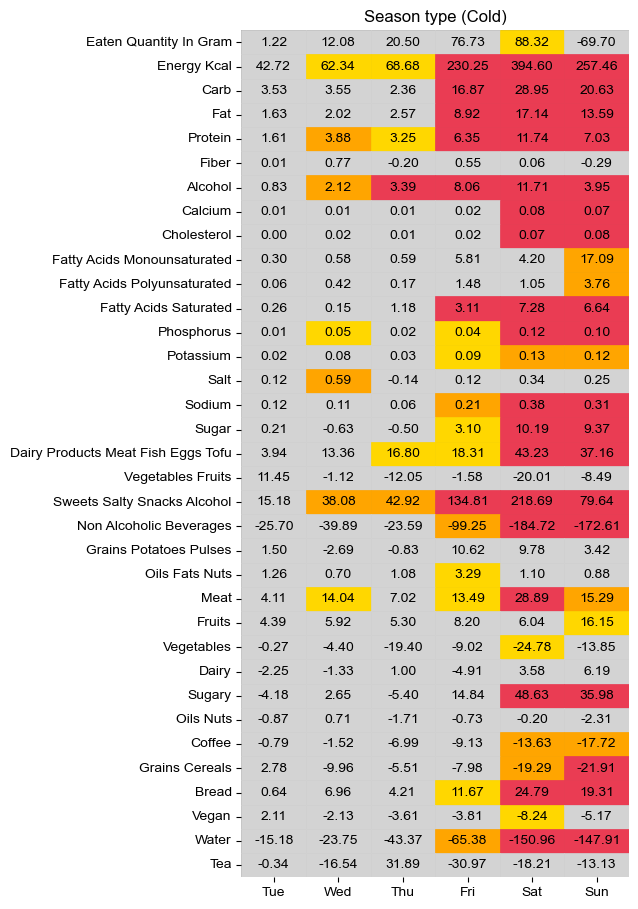

In [15]:
fay_with_summedFood_x = fay[
    ["age", "bmi", "gender", "subject_app_key", "season_type"]
].merge(df_food_filtered_agg, left_on="subject_app_key", right_on="subject_key")

fay_with_summedFood_subset = fay_with_summedFood_x[
    fay_with_summedFood_x["season_type"] == "cold"
]
print(fay_with_summedFood_subset.shape)

lmm_res_dof_coeff, lmm_res_dof_pval, _ = compute_lmm_results(
    fay_with_summedFood_subset, df_food_filtered_agg.columns
)

plot_lmm_heatmap_with_coeff_and_pval(
    df=lmm_res_dof_pval.T,
    coef_data=lmm_res_dof_coeff.T,
    title="Season type (Cold)",
    save_path="figures/lmm/lmm_heatmap_cold.png",
    hide_image=False,
)

(3094, 59)


100%|██████████| 54/54 [00:14<00:00,  3.78it/s]
/var/folders/kl/wv2_2q3n4z3d2bxtztx97rgc0000gn/T/ipykernel_49601/2065938182.py:50: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle(


Convergence warnings for 13 columns: ['beta_carotene_eaten', 'folate_eaten', 'iron_eaten', 'magnesium_eaten', 'niacin_eaten', 'pantothenic_acid_eaten', 'vitamin_b1_eaten', 'vitamin_b12_eaten', 'vitamin_b2_eaten', 'vitamin_b6_eaten', 'vitamin_c_eaten', 'vitamin_d_eaten', 'zinc_eaten']


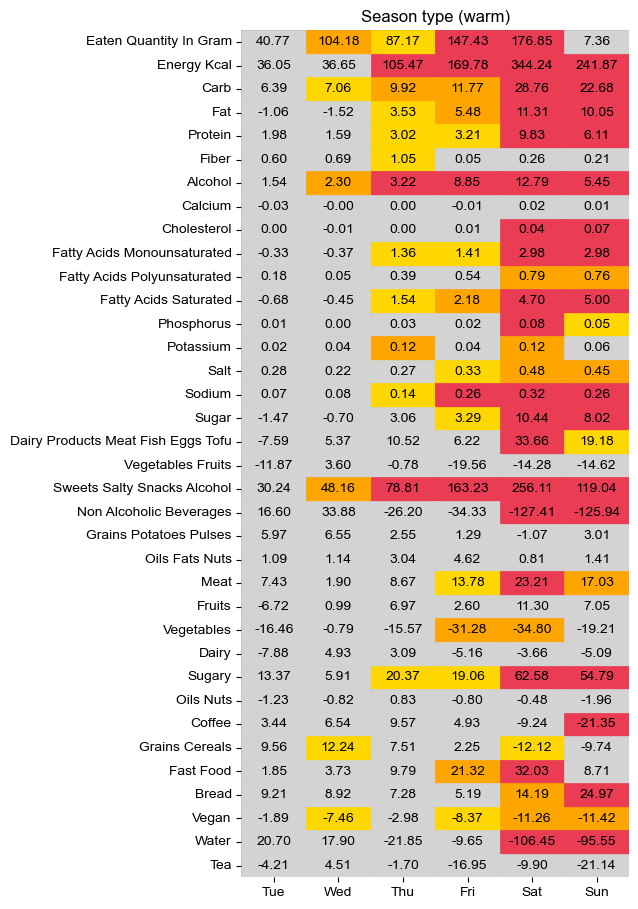

In [16]:
fay_with_summedFood_x = fay[
    ["age", "bmi", "gender", "subject_app_key", "season_type"]
].merge(df_food_filtered_agg, left_on="subject_app_key", right_on="subject_key")

fay_with_summedFood_subset = fay_with_summedFood_x[
    fay_with_summedFood_x["season_type"] == "warm"
]
print(fay_with_summedFood_subset.shape)

lmm_res_dof_coeff, lmm_res_dof_pval, _ = compute_lmm_results(
    fay_with_summedFood_subset, df_food_filtered_agg.columns
)

plot_lmm_heatmap_with_coeff_and_pval(
    df=lmm_res_dof_pval.T,
    coef_data=lmm_res_dof_coeff.T,
    title="Season type (warm)",
    save_path="figures/lmm/lmm_heatmap_warm.png",
    hide_image=False,
)